# Setup

In [108]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import datetime
import pandas as pd

from pandas import DataFrame,Series,read_table

General info

In [109]:
savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig 03/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsName = 'Fig3'

In [110]:
#path = '/Users/svcanavan/Dropbox/Coding in progress/00_BudgieSleep/Data_copies/'

birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['6 LEEGm-LEEGp', '5 LEEGf-LEEGp'], #, '9 REEGp-LEEGp'], # extra channel to represent R hemisphere
                     ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'], #, '9 REEGf-REEGm'], # extra channel to represent R hemisphere
                     ['9REEGm-REEGp', '4LEEGf-LEEGp'], 
                     ['6LEEGm-LEEGf', '9REEGf-REEGp'], 
                     ['7REEGf-REEGp', '4LEEGf-LEEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'

## Path to detect SW ands EM events: use folder w/ EMs and EM artifacts detected during non-sleep
events_path = '../data_copies/SWs_EMs_and_EMartifacts/'

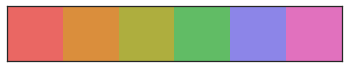

In [111]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

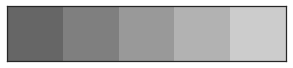

In [112]:
colors_birds = [np.repeat(.4, 3),
                np.repeat(.5, 3),
                np.repeat(.6, 3),
                np.repeat(.7, 3),
                np.repeat(.8, 3)]

sns.palplot(colors_birds)


Plot-specific info

In [113]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7))  

Calculate general variables

In [114]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

## LEGEND: bird colors

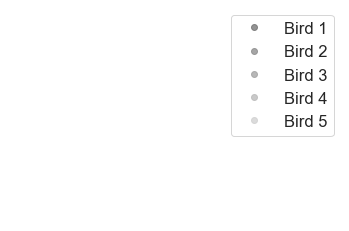

In [115]:
# Markers for bird colors
legendMarkers_birds = []
for b in range(nBirds):
    legendMarkers_birds.append(plt.Line2D([0],[0], marker='o', color=colors_birds[b], linestyle='', alpha=0.7))  
plt.legend(legendMarkers_birds, ['Bird 1', 'Bird 2', 'Bird 3', 'Bird 4', 'Bird 5'])
sns.despine(bottom=True, left=True)
plt.yticks([])
plt.xticks([])


if savePlots:
        plt.savefig(saveAsPath + saveAsName + "a-d_bird_color_legend.pdf")

## Load formatted scores

In [116]:
AllScores = {}
for b in range(nBirds):
    bird_name = 'Bird ' + str(b+1)
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    AllScores[bird_name] = data

## Calculate lights off in Zeitgeber time (s and hrs)
Lights on is 0 

In [117]:
lightsOffDatetime = np.array([], dtype='datetime64')
lightsOnDatetime = np.array([], dtype='datetime64')

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    startDatetime = np.datetime64(Scores.index.values[0])

    # Calc lights off & on using datetime formats
    lightsOffTimedelta = lightsOffSec[b_num].astype('timedelta64[s]')
    lightsOffDatetime = np.append(lightsOffDatetime, startDatetime + lightsOffTimedelta)
    lightsOnTimedelta = lightsOnSec[b_num].astype('timedelta64[s]')
    lightsOnDatetime = np.append(lightsOnDatetime, startDatetime + lightsOnTimedelta)

In [118]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

# With all sleep stages separately

## Merge continuous epochs of the same stage, same length & start time

In [119]:
ScoresMerged = {}

for key in AllScores.keys():

    scores = AllScores[key]
    
    # add a "stop" column
    scores['Stop (s)'] = scores['Time (s)'] + epochLength
    
    original_end_s = scores['Stop (s)'].iloc[-1]
    
    # add a dummy row wherever there is a gap between epochs
    gaps = np.where(scores['Stop (s)'] != scores['Time (s)'].shift(-1))[0]
    gaps = gaps[0:-1] # don't include the last row of the file as a gap
    gap_datetimes = scores.iloc[gaps].index.astype('datetime64') + np.timedelta64(3, 's')

    lines = pd.DataFrame({'Time (s)': scores['Stop (s)'].iloc[gaps].values,
                          'Stop (s)': scores['Time (s)'].iloc[gaps+1].values,
                          'Label': 'gap'}, index=gap_datetimes.astype('str'))
    scores = scores.append(lines, ignore_index=False)
    scores = scores.sort_index()
    
    # add a datetime column
    scores['datetime'] = scores.index
                
    # add a column to keep track of consecutive epochs of the same stage
    scores['episode #'] = (scores['Label'] != scores['Label'].shift(1)).astype(int).cumsum()
        # don't worry about the gaps where the video recording restarted
        # if the behavior is the same before and after the gap, count it as a continuous episode
        # if you want to split episodes where the gap occurs, add:
        #     (scores['Stop (s)'] == scores['Time (s)'].shift(-1))
    
    # combine all epochs of the same episode # and use the values from the first epoch of that episode
    merged_scores = scores.groupby(scores['episode #'], sort=False).aggregate('first')
    
    # calculate length of each episode
    lengths = merged_scores['Time (s)'].shift(-1) - merged_scores['Time (s)']
    lengths.iloc[-1] = original_end_s - merged_scores['Time (s)'].iloc[-1]
    
    merged_scores['Length (s)'] = lengths
    
    # set index back to datetime
    merged_scores.index = merged_scores['datetime']
    
    gap_rows =merged_scores[merged_scores['Label']=='gap'].index
    merged_scores = merged_scores.drop(gap_rows)
    
    ScoresMerged[key] = merged_scores

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:346: FutureWarning: Passing in 'datetime64' dtype with no precision is deprecated
and will raise in a future version. Please pass in
'datetime64[ns]' instead.
  data, copy=copy, name=name, dtype=dtype, **kwargs
/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [120]:
# Check lengths
print(len(AllScores['Bird 5']) * epochLength/3600) # original

print(ScoresMerged['Bird 5']['Length (s)'].sum()/3600) # merged


23.905833333333334
23.905833333333334


### Save to csv

In [121]:
if saveData:
    for b in range(nBirds):

        b_name = 'Bird ' + str(b+1)

        scores = ScoresMerged[b_name]
        scores.to_csv(saveAsPath + saveAsName + '_scores_merged_' + b_name + '.csv')

## Frequency of episodes of each stage per bin

In [122]:
binSize_min = 60

binSize_s = np.timedelta64(int(binSize_min*60), 's')

stageProportions_whole_night_all = {}

for b in range(nBirds):
    nBins = int(np.ceil(np.min(lightsOnSec - lightsOffSec)/(60*binSize_min)))

    stageProportions = DataFrame([], columns=range(len(stages)))

    b_name = 'Bird ' + str(b+1)
    Scores = ScoresMerged[b_name]

    for bn in range(nBins):

        start_time = str(lightsOffDatetime[b] + bn*binSize_s).replace('T', ' ')
        end_time   = str(lightsOffDatetime[b] + (bn+1)*binSize_s).replace('T', ' ')

        bn_scores = Scores[str(start_time):str(end_time)]
        bn_stage_frequencies = bn_scores['Label (#)'].value_counts(sort=False)
                
        stageProportions = stageProportions.append(bn_stage_frequencies, ignore_index=True)
    
    # Replace NaNs with 0
    stageProportions = stageProportions.fillna(0)

    # Add to dictionary
    stageProportions_whole_night_all[b] = stageProportions
    

### Save to csv

In [123]:
if saveData:
    for b in range(nBirds):
        b_name = 'Bird ' + str(b+1)

        stageProportions = stageProportions_whole_night_all[b]
        stageProportions.to_csv(saveAsPath + saveAsName + 'c_stage_frequencies_' + b_name + '.csv')

### FIGURE 3C: Plot

In [124]:
figsize = (8,6)
axis_label_fontsize = 24

# Line formatting
linewidth = 5
linealpha = .7
marker = 'o'
markersize = 10
err_capsize = 3
err_capthick = 3
elinewidth = 3

# Bar formatting
bar_linewidth = 4

i : mean 164.6727272727273, SD 25.31027949142175
s : mean 102.9090909090909, SD 26.014172869469537
r : mean 79.98181818181817, SD 10.878502570750175


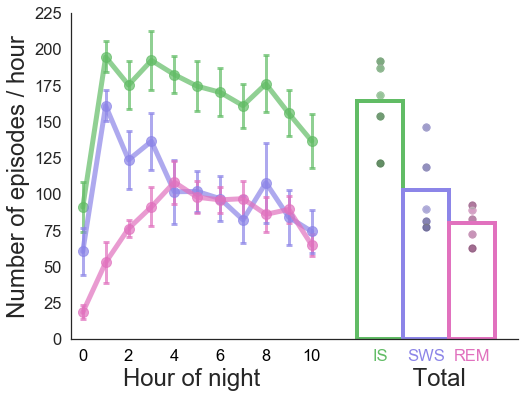

In [125]:
plt.figure(figsize=figsize)

bird_means_by_stage = pd.DataFrame([])
All_per_bin_means = pd.DataFrame([])

for st in range(len(stages[3:6])):

    st_freqs = np.zeros((nBins, nBirds))
    bird_means = np.zeros(nBirds)
    for b in range(nBirds):

        stageProportions = stageProportions_whole_night_all[b]

        st_freqs[:,b] = stageProportions[st+3]
        
        bird_means[b] = np.mean(stageProportions[st+3])

    nighttime_mean = np.mean(st_freqs)
    per_bin_mean = np.mean(st_freqs, axis=1)
    per_bin_sd = np.std(st_freqs, axis=1)
    per_bin_sem = per_bin_sd / np.sqrt(nBirds)
        
    # save to dataframe
    All_per_bin_means[st+3] = per_bin_mean

    plt.errorbar(range(nBins), per_bin_mean, yerr=per_bin_sem,
                color=colors[3:6][st], linewidth=linewidth, alpha=linealpha,
                marker=marker, markersize=markersize,
                capsize=err_capsize, capthick=err_capthick, elinewidth=elinewidth);
    
    # Dots marking nighttime mean of each bird
    plt.scatter(np.ones(nBirds)*(nBins+2+(st*2)), bird_means, 50, color=colors[3:6][st]);
    
    # Bar graph of mean across all birds
    plt.bar(nBins+2+(st*2), np.mean(bird_means), width=2, color='none',edgecolor=colors[3:6][st], linewidth=bar_linewidth);
    
    print(stages[3:6][st] + ' : mean ' + str(np.mean(bird_means)) + ', SD ' + str(np.std(bird_means)))
    bird_means_by_stage[stages[3:6][st]] = bird_means
    
# Dots color coded by bird
for b in range(nBirds):
    plt.scatter(nBins+(np.arange(0,3)*2)+2, 
             bird_means_by_stage.loc[b], 50, color=colors_birds[b], alpha=.5)
    
    
plt.ylim(0,225)
plt.xlim(-.5,19)

# x tick labels: label each bar of the bar graph separately
c = (0,0,0)
plt.xticks([0,2,4,6,8,10,13,15,17], [0,2,4,6,8,10, 'IS', 'SWS','REM']);
ax = plt.gca()
[t.set_color(i) for (i,t) in zip([c,c,c,c,c,c,colors[3],colors[4],colors[5]],ax.xaxis.get_ticklabels())]

plt.ylabel('Number of episodes / hour', fontsize=axis_label_fontsize)
plt.xlabel('Hour of night                       Total', fontsize=axis_label_fontsize)
 
sns.despine()
    
if savePlots:
        plt.savefig(saveAsPath + saveAsName + "c_frequencies.pdf")

### FIGURE 3C: STATISTICS

In [126]:
# One-way ANOVA: mean frequencies
stat.f_oneway(bird_means_by_stage['i'],bird_means_by_stage['s'], bird_means_by_stage['r'])

F_onewayResult(statistic=16.0382292261499, pvalue=0.0004072370909314963)

In [127]:
# Mean frequencies: IS vs REM
stat.ttest_rel(bird_means_by_stage['i'], bird_means_by_stage['r'])

Ttest_relResult(statistic=7.310015257613437, pvalue=0.001862726905038296)

In [128]:
# Mean frequencies: SWS vs REM
stat.ttest_rel(bird_means_by_stage['s'], bird_means_by_stage['r'])

Ttest_relResult(statistic=1.5431170521473294, pvalue=0.19767370570831563)

In [131]:
# Mean frequencies: IS vs SWS
stat.ttest_rel(bird_means_by_stage['i'], bird_means_by_stage['s'])

Ttest_relResult(statistic=7.712212936328445, pvalue=0.001521457587853904)

In [76]:
# IS: regression with hour of night
test = All_per_bin_means[3]

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = -0.0018181818181822317 , r2 = 4.207263250987887e-08 , p = 0.9995224466780807


In [135]:
# IS: regression with hour of night
test = All_per_bin_means[3][1:] # FIRST HOUR OMITTED

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = -4.900606060606061 , r2 = 0.732465049967923 , p = 0.0015818264642422173


In [77]:
# SWS: regression with hour of night
test = All_per_bin_means[4]

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = -3.6327272727272715 , r2 = 0.1726966520589901 , p = 0.20369015541009844


In [134]:
# SWS: regression with hour of night
test = All_per_bin_means[4][1:] # FIRST HOUR OMITTED

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = -7.664242424242423 , r2 = 0.7528924210890774 , p = 0.0011392692535196122


In [78]:
# REM: regression with hour of night
test = All_per_bin_means[5]

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = 3.698181818181817 , r2 = 0.2252302847909687 , p = 0.14022155928550747


In [133]:
# REM: regression with hour of night
test = All_per_bin_means[5][1:] # FIRST HOUR OMITTED

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = 0.838787878787878 , r2 = 0.022897306014779267 , p = 0.6764663179233157


## Duration of episodes of each stage per bin

In [79]:
binSize_min = 60

binSize_s = np.timedelta64(int(binSize_min*60), 's')

stageProportions_whole_night_all = {}

for b in range(nBirds):
    nBins = int(np.ceil(np.min(lightsOnSec - lightsOffSec)/(60*binSize_min)))

    stageProportions = DataFrame([], columns=range(len(stages)))

    b_name = 'Bird ' + str(b+1)
    Scores = ScoresMerged[b_name]

    for bn in range(nBins):

        start_time = str(lightsOffDatetime[b] + bn*binSize_s).replace('T', ' ')
        end_time   = str(lightsOffDatetime[b] + (bn+1)*binSize_s).replace('T', ' ')

        bn_scores = Scores[start_time:end_time]
        
        bn_stage_lengths = np.array([])
        for st in range(len(stages)):
            bn_st_episodes = bn_scores[bn_scores['Label (#)'] == st]
            if len(bn_st_episodes) > 0:
                bn_avg_length = bn_st_episodes['Length (s)'].mean(0)
            else:
                bn_avg_length = np.nan
            bn_stage_lengths = np.append(bn_stage_lengths, bn_avg_length)
                        
        stageProportions.loc[bn] = bn_stage_lengths

    # Add to dictionary
    stageProportions_whole_night_all[b] = stageProportions
    

### FIGURE 3A: Plot

i : mean 9.246904631604412, SD 1.250965921913051
s : mean 5.134153837328954, SD 0.789065355060224
r : mean 11.26150728060531, SD 5.060989008212911


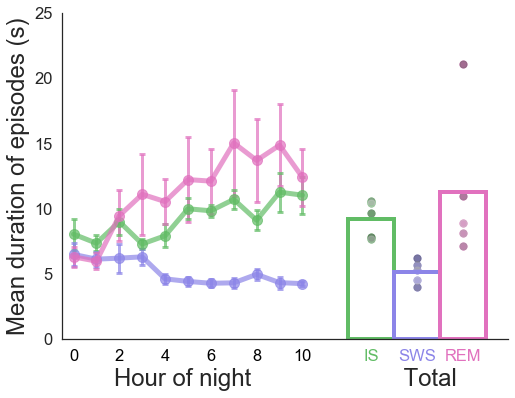

In [80]:
plt.figure(figsize=figsize)

bird_means_by_stage = pd.DataFrame([]) # init
All_per_bin_means = pd.DataFrame([])

for st in range(len(stages[3:6])):

    st_lengths = np.zeros((nBins, nBirds))
    bird_means = np.zeros(nBirds)
    for b in range(nBirds):

        stageProportions = stageProportions_whole_night_all[b]

        st_lengths[:,b] = stageProportions[st+3]
        
        bird_means[b] = np.mean(stageProportions[st+3])

    nighttime_mean = np.mean(st_lengths)
    per_bin_mean = np.mean(st_lengths, axis=1)
    per_bin_sd = np.std(st_lengths, axis=1)
    per_bin_sem = per_bin_sd / np.sqrt(nBirds)
    
    # save to dataframe
    All_per_bin_means[st+3] = per_bin_mean

    plt.errorbar(range(nBins), per_bin_mean, yerr=per_bin_sem, color=colors[3:6][st],
                linewidth=linewidth, alpha=linealpha,
                marker=marker, markersize=markersize,
                capsize=err_capsize, capthick=err_capthick, elinewidth=elinewidth);
    
    # Dots marking nighttime mean of each bird
    plt.scatter(np.ones(nBirds)*(nBins+(st*2)+2), bird_means, 50, color=colors[3:6][st]);
    
    # Bar graph of mean across all birds
    plt.bar(nBins+(st*2)+2, np.mean(bird_means), width=2, color='none',edgecolor=colors[3:6][st], linewidth=bar_linewidth);
    
    print(stages[3:6][st] + ' : mean ' + str(np.mean(bird_means)) + ', SD ' + str(np.std(bird_means)))
    bird_means_by_stage[stages[3:6][st]] = bird_means
    
# Dots color coded by bird
for b in range(nBirds):
    plt.scatter(nBins+(np.arange(0,3)*2)+2, 
             bird_means_by_stage.loc[b], 50, color=colors_birds[b], alpha=.5)

plt.ylim(0,25)
plt.xlim(-.5,19)

# x tick labels: label each bar of the bar graph separately
c = (0,0,0)
plt.xticks([0,2,4,6,8,10,13,15,17], [0,2,4,6,8,10,'IS', 'SWS','REM']);
ax = plt.gca()
[t.set_color(i) for (i,t) in zip([c,c,c,c,c,c,colors[3],colors[4],colors[5]],ax.xaxis.get_ticklabels())]

plt.ylabel('Mean duration of episodes (s)', fontsize=axis_label_fontsize)
plt.xlabel('Hour of night                       Total', fontsize=axis_label_fontsize)

sns.despine()

if savePlots:
        plt.savefig(saveAsPath + saveAsName + "a_durations.pdf")

### FIGURE 3A STATISTICS

In [81]:
# One-way ANOVA: mean durations
stat.f_oneway(bird_means_by_stage['i'],bird_means_by_stage['s'], bird_means_by_stage['r'])

F_onewayResult(statistic=4.2097398101399115, pvalue=0.04119262379369538)

In [82]:
# Mean durations: IS vs REM
stat.ttest_rel(bird_means_by_stage['i'], bird_means_by_stage['r'])

Ttest_relResult(statistic=-0.6888103350245784, pvalue=0.5288140987173507)

In [83]:
# Mean durations: SWS vs REM
stat.ttest_rel(bird_means_by_stage['s'], bird_means_by_stage['r'])

Ttest_relResult(statistic=-2.588750873524876, pvalue=0.060763871462579035)

In [84]:
# Mean durations: SWS vs IS
stat.ttest_rel(bird_means_by_stage['s'], bird_means_by_stage['i'])

Ttest_relResult(statistic=-4.671468568868213, pvalue=0.00950790817839959)

In [85]:
# IS: regression with hour of night
test = All_per_bin_means[3]

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = 0.3606111319295407 , r2 = 0.6813777712756139 , p = 0.0017529352370463235


In [86]:
# SWS: regression with hour of night
test = All_per_bin_means[4]

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = -0.24056236891664864 , r2 = 0.7080237477666089 , p = 0.0011658502864583798


In [87]:
# REM: regression with hour of night
test = All_per_bin_means[5]

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = 0.8017961761027387 , r2 = 0.7649437977969713 , p = 0.00042632071896564987


## Save as csv

In [88]:
if saveData:
    for b in range(nBirds):
        b_name = 'Bird ' + str(b+1)

        stageProportions = stageProportions_whole_night_all[b]
        stageProportions.to_csv(saveAsPath + saveAsName + 'a_stage_durations_' + b_name + '.csv')

# With NREM stages lumped

In [89]:
# THIS NOTEBOOK ONLY:
stages = ['w','d','u', 'n', 'n','r'] # wake, drowsy, unihem sleep, NREM, REM
stagesSleep =    ['u','n', 'n','r']

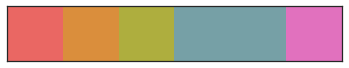

In [90]:
# THIS NOTEBOOK ONLY - LUMP NREM:
NREM_color = np.median(np.array([[97,188,101],
[140,133,232]]),axis=0)

colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
NREM_color,
NREM_color,                                     
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

## Reload formatted scores and replace IS and SWS with just "NREM"

In [91]:
AllScores = {}
for b in range(nBirds):
    bird_name = 'Bird ' + str(b+1)
    file = formatted_scores_path + 'All_scores_' + bird_name + '.csv'
    data = pd.read_csv(file, index_col=0)
    
    labels = data['Label'].replace(to_replace=np.nan, value='u').values
    label_nums = data['Label (#)'].values
    indsNREM = [x for x in range(int(len(labels))) if ('i' in labels[x])|('s' in labels[x])]
    for ind in indsNREM:
        labels[ind] = 'n' 
        label_nums[ind] = 4
    data['Label'] = labels
    data['Label (#)'] = label_nums
    
    AllScores[bird_name] = data

## Calculate lights off in Zeitgeber time (s and hrs)
Lights on is 0 

In [92]:
lightsOffDatetime = np.array([], dtype='datetime64')
lightsOnDatetime = np.array([], dtype='datetime64')

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    startDatetime = np.datetime64(Scores.index.values[0])

    # Calc lights off & on using datetime formats
    lightsOffTimedelta = lightsOffSec[b_num].astype('timedelta64[s]')
    lightsOffDatetime = np.append(lightsOffDatetime, startDatetime + lightsOffTimedelta)
    lightsOnTimedelta = lightsOnSec[b_num].astype('timedelta64[s]')
    lightsOnDatetime = np.append(lightsOnDatetime, startDatetime + lightsOnTimedelta)

In [93]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

## Merge continuous epochs of the same stage, same length & start time

In [94]:
ScoresMerged = {}

for key in AllScores.keys():

    scores = AllScores[key]
    
    # add a "stop" column
    scores['Stop (s)'] = scores['Time (s)'] + epochLength
    
    original_end_s = scores['Stop (s)'].iloc[-1]
    
    # add a dummy row wherever there is a gap between epochs
    gaps = np.where(scores['Stop (s)'] != scores['Time (s)'].shift(-1))[0]
    gaps = gaps[0:-1] # don't include the last row of the file as a gap
    gap_datetimes = scores.iloc[gaps].index.astype('datetime64') + np.timedelta64(3, 's')

    lines = pd.DataFrame({'Time (s)': scores['Stop (s)'].iloc[gaps].values,
                          'Stop (s)': scores['Time (s)'].iloc[gaps+1].values,
                          'Label': 'gap'}, index=gap_datetimes.astype('str'))
    scores = scores.append(lines, ignore_index=False)
    scores = scores.sort_index()
    
    # add a datetime column
    scores['datetime'] = scores.index
                
    # add a column to keep track of consecutive epochs of the same stage
    scores['episode #'] = (scores['Label'] != scores['Label'].shift(1)).astype(int).cumsum()
        # don't worry about the gaps where the video recording restarted
        # if the behavior is the same before and after the gap, count it as a continuous episode
        # if you want to split episodes where the gap occurs, add:
        #     (scores['Stop (s)'] == scores['Time (s)'].shift(-1))
    
    # combine all epochs of the same episode # and use the values from the first epoch of that episode
    merged_scores = scores.groupby(scores['episode #'], sort=False).aggregate('first')
    
    # calculate length of each episode
    lengths = merged_scores['Time (s)'].shift(-1) - merged_scores['Time (s)']
    lengths.iloc[-1] = original_end_s - merged_scores['Time (s)'].iloc[-1]
    
    merged_scores['Length (s)'] = lengths
    
    # set index back to datetime
    merged_scores.index = merged_scores['datetime']
    
    gap_rows =merged_scores[merged_scores['Label']=='gap'].index
    merged_scores = merged_scores.drop(gap_rows)
    
    ScoresMerged[key] = merged_scores

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:346: FutureWarning: Passing in 'datetime64' dtype with no precision is deprecated
and will raise in a future version. Please pass in
'datetime64[ns]' instead.
  data, copy=copy, name=name, dtype=dtype, **kwargs
/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [95]:
# Check lengths
print(len(AllScores['Bird 5']) * epochLength/3600) # original

print(ScoresMerged['Bird 5']['Length (s)'].sum()/3600) # merged


23.905833333333334
23.905833333333334


## Frequency of episodes of each stage per bin

In [96]:
binSize_min = 60

binSize_s = np.timedelta64(int(binSize_min*60), 's')

stageProportions_whole_night_all = {}


for b in range(nBirds):
    nBins = int(np.ceil(np.min(lightsOnSec - lightsOffSec)/(60*binSize_min)))

    stageProportions = DataFrame([], columns=range(len(stages)))

    b_name = 'Bird ' + str(b+1)
    Scores = ScoresMerged[b_name]

    for bn in range(nBins):

        start_time = str(lightsOffDatetime[b] + bn*binSize_s).replace('T', ' ')
        end_time   = str(lightsOffDatetime[b] + (bn+1)*binSize_s).replace('T', ' ')

        bn_scores = Scores[str(start_time):str(end_time)]
        bn_stage_frequencies = bn_scores['Label (#)'].value_counts(sort=False)
                
        stageProportions = stageProportions.append(bn_stage_frequencies, ignore_index=True)
    
    # Replace NaNs with 0
    stageProportions = stageProportions.fillna(0)

    # Add to dictionary
    stageProportions_whole_night_all[b] = stageProportions
    

### save to csv

In [97]:
if saveData:
    for b in range(nBirds):
        b_name = 'Bird ' + str(b+1)

        stageProportions = stageProportions_whole_night_all[b]
        stageProportions.to_csv(saveAsPath + saveAsName + 'd_NREM_lumped_stage_frequencies_' + b_name + '.csv')

### FIGURE  3D Plot

In [98]:
figsize = (8,6)
axis_label_fontsize = 24

# Line formatting
linewidth = 5
linealpha = .7
marker = 'o'
markersize = 10
err_capsize = 3
err_capthick = 3
elinewidth = 3

# Bar formatting
bar_linewidth = 4

n : mean 90.14545454545456, SD 7.945808188510155
r : mean 79.98181818181817, SD 10.878502570750175


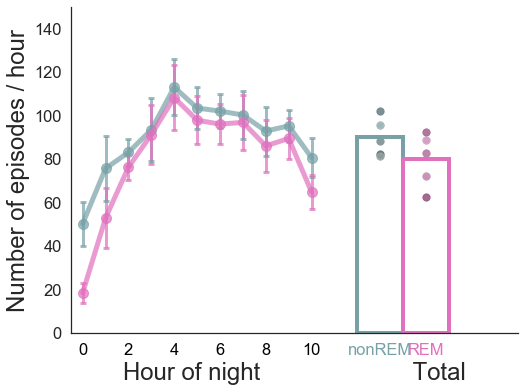

In [99]:
plt.figure(figsize=figsize)

bird_means_by_stage = pd.DataFrame([])
All_per_bin_means = pd.DataFrame([])

for st in range(len(stages[4:6])):

    st_freqs = np.zeros((nBins, nBirds))
    bird_means = np.zeros(nBirds)
    for b in range(nBirds):

        stageProportions = stageProportions_whole_night_all[b]

        st_freqs[:,b] = stageProportions[st+4]
        
        bird_means[b] = np.mean(stageProportions[st+4])

    nighttime_mean = np.mean(st_freqs)
    per_bin_mean = np.mean(st_freqs, axis=1)
    per_bin_sd = np.std(st_freqs, axis=1)
    per_bin_sem = per_bin_sd / np.sqrt(nBirds)
    
    # save to dataframe
    All_per_bin_means[st+4] = per_bin_mean

    plt.errorbar(range(nBins), per_bin_mean, yerr=per_bin_sem,
                color=colors[4:6][st], linewidth=linewidth, alpha=linealpha,
                marker=marker, markersize=markersize,
                capsize=err_capsize, capthick=err_capthick, elinewidth=elinewidth);
    
    # Dots marking nighttime mean of each bird
    plt.scatter(np.ones(nBirds)*(nBins+2+(st*2)), bird_means, 50, color=colors[4:6][st]);
    
    # Bar graph of mean across all birds
    plt.bar(nBins+2+(st*2), np.mean(bird_means), width=2, color='none',edgecolor=colors[4:6][st], linewidth=bar_linewidth);
    
    print(stages[4:6][st] + ' : mean ' + str(np.mean(bird_means)) + ', SD ' + str(np.std(bird_means)))
    bird_means_by_stage[stages[4:6][st]] = bird_means

    
# Dots color coded by bird
for b in range(nBirds):
    plt.scatter(nBins+(np.arange(0,2)*2)+2, 
                bird_means_by_stage.loc[b], 50, color=colors_birds[b], alpha=.5)
    
plt.ylim(0,150)
plt.xlim(-.5,19)

# x tick labels: label each bar of the bar graph separately
c = (0,0,0)
plt.xticks([0,2,4,6,8,10,13,15], [0,2,4,6,8,10,'nonREM','REM']);
ax = plt.gca()
[t.set_color(i) for (i,t) in zip([c,c,c,c,c,c,colors[4],colors[5]],ax.xaxis.get_ticklabels())]

plt.ylabel('Number of episodes / hour', fontsize=axis_label_fontsize)
plt.xlabel('Hour of night                       Total', fontsize=axis_label_fontsize)

sns.despine()

if savePlots:
        plt.savefig(saveAsPath + saveAsName + "d_NREM_lumped_frequencies.pdf")

### FIGURE 3D: STATISTICS

In [100]:
# Mean frequencies: NREM vs REM
stat.ttest_rel(bird_means_by_stage['n'], bird_means_by_stage['r'])

Ttest_relResult(statistic=4.148315915311524, pvalue=0.014279779796079617)

In [101]:
# NREM: regression with hour of night
test = All_per_bin_means[4]

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = 2.3854545454545453 , r2 = 0.21350373835948772 , p = 0.15247522575946523


## Duration of episodes of each stage per bin

In [102]:
binSize_min = 60

binSize_s = np.timedelta64(int(binSize_min*60), 's')

stageProportions_whole_night_all = {}

for b in range(nBirds):
    nBins = int(np.ceil(np.min(lightsOnSec - lightsOffSec)/(60*binSize_min)))

    stageProportions = DataFrame([], columns=range(len(stages)))

    b_name = 'Bird ' + str(b+1)
    Scores = ScoresMerged[b_name]

    for bn in range(nBins):

        start_time = str(lightsOffDatetime[b] + bn*binSize_s).replace('T', ' ')
        end_time   = str(lightsOffDatetime[b] + (bn+1)*binSize_s).replace('T', ' ')

        bn_scores = Scores[start_time:end_time]
        
        bn_stage_lengths = np.array([])
        for st in range(len(stages)):
            bn_st_episodes = bn_scores[bn_scores['Label (#)'] == st]
            if len(bn_st_episodes) > 0:
                bn_avg_length = bn_st_episodes['Length (s)'].mean(0)
            else:
                bn_avg_length = np.nan
            bn_stage_lengths = np.append(bn_stage_lengths, bn_avg_length)
                        
        stageProportions.loc[bn] = bn_stage_lengths

    # Add to dictionary
    stageProportions_whole_night_all[b] = stageProportions
    

### FIGURE 3B: Plot

n : mean 25.059823683308498, SD 6.556666048684886
r : mean 11.26150728060531, SD 5.060989008212911


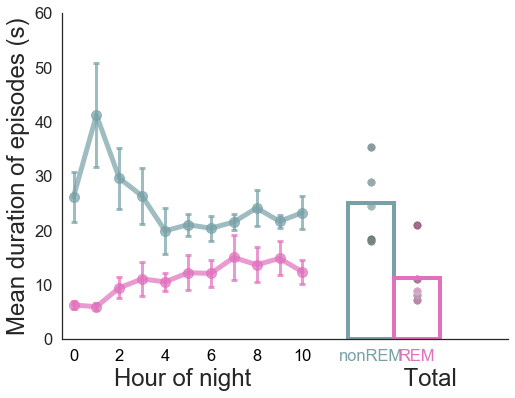

In [103]:
plt.figure(figsize=figsize)

bird_means_by_stage = pd.DataFrame([])
All_per_bin_means = pd.DataFrame([])

for st in range(len(stages[4:6])):

    st_lengths = np.zeros((nBins, nBirds))
    bird_means = np.zeros(nBirds)
    for b in range(nBirds):

        stageProportions = stageProportions_whole_night_all[b]

        st_lengths[:,b] = stageProportions[st+4]
        
        bird_means[b] = np.mean(stageProportions[st+4])

    nighttime_mean = np.mean(st_lengths)
    per_bin_mean = np.mean(st_lengths, axis=1)
    per_bin_sd = np.std(st_lengths, axis=1)
    per_bin_sem = per_bin_sd / np.sqrt(nBirds)

    # save to dataframe
    All_per_bin_means[st+4] = per_bin_mean
    
    plt.errorbar(range(nBins), per_bin_mean, yerr=per_bin_sem, color=colors[4:6][st],
                linewidth=linewidth, alpha=linealpha,
                marker=marker, markersize=markersize,
                capsize=err_capsize, capthick=err_capthick, elinewidth=elinewidth);
    
    # Dots marking nighttime mean of each bird
    plt.scatter(np.ones(nBirds)*(nBins+(st*2)+2), bird_means, 50, color=colors[4:6][st]);
    
    # Bar graph of mean across all birds
    plt.bar(nBins+(st*2)+2, np.mean(bird_means), width=2, color='none',edgecolor=colors[4:6][st], linewidth=bar_linewidth);
    
    print(stages[4:6][st] + ' : mean ' + str(np.mean(bird_means)) + ', SD ' + str(np.std(bird_means)))
    bird_means_by_stage[stages[4:6][st]] = bird_means
    
# Dots color coded by bird
for b in range(nBirds):
    plt.scatter(nBins+(np.arange(0,2)*2)+2, 
                bird_means_by_stage.loc[b], 50, color=colors_birds[b], alpha=.5)
    
    
plt.ylim(0,60)
plt.xlim(-.5,19)

# x tick labels: label each bar of the bar graph separately
c = (0,0,0)
plt.xticks([0,2,4,6,8,10,13,15], [0,2,4,6,8,10,'nonREM','REM']);
ax = plt.gca()
[t.set_color(i) for (i,t) in zip([c,c,c,c,c,c,colors[4],colors[5]],ax.xaxis.get_ticklabels())]

plt.ylabel('Mean duration of episodes (s)', fontsize=axis_label_fontsize)
plt.xlabel('Hour of night                       Total', fontsize=axis_label_fontsize)

sns.despine()

if savePlots:
        plt.savefig(saveAsPath + saveAsName + "b_NREM_lumped_durations.pdf")
        

### FIGURE 3B STATISTICS

In [104]:
# Mean durations: NREM vs REM
stat.ttest_rel(bird_means_by_stage['n'], bird_means_by_stage['r'])

Ttest_relResult(statistic=2.5713006034303616, pvalue=0.06189362132781688)

In [105]:
# NREM: regression with hour of night
test = All_per_bin_means[4]

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = -1.0748672504921193 , r2 = 0.3375036895087704 , p = 0.060896633283737865


In [106]:
# NREM: regression with hour of night
test = All_per_bin_means[4][1:] # ONLY SIGNIFICANT IF FIRST HOUR OMITTED

slope, intercept, r_value, p_value, std_err = stat.linregress(test.index.values, test.values)
print('slope =', slope, ', r2 =', r_value**2, ', p =', p_value)

slope = -1.3562427985389598 , r2 = 0.4045730640042001 , p = 0.04805153416194467


## Save as csv

In [107]:
if saveData:
    for b in range(nBirds):
        b_name = 'Bird ' + str(b+1)

        stageProportions = stageProportions_whole_night_all[b]
        stageProportions.to_csv(saveAsPath + saveAsName + 'b_NREM_lumped_stage_durations_' + b_name + '.csv')